## Full FineTuning, LoRa and QLoRa

In [1]:
import transformers
from datasets import load_dataset

# Get dataset
dataset=load_dataset("yelp_review_full")
print(dataset["train"][0])

{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}


In [2]:
from transformers import AutoTokenizer

# Tokenize data

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [3]:
from transformers import AutoModelForSequenceClassification

# Load pretrained model from huggingface
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# For cost reasons I trained model on smaller dataset
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(20000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))

### Full Model Fine-Tuning

In [20]:
from transformers import TrainingArguments

# Define TrainingArguments
training_args = TrainingArguments(
    auto_find_batch_size=True,
    num_train_epochs=3, #increase for more accuracy
    logging_steps=100,
    report_to = "none",
    output_dir="test_trainer",
)

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define metrics with which I will evaluate the models
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [21]:
from transformers import Trainer

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [9]:
# Evaluate model before training
trainer.evaluate() # Model currently guesses randomly

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.6747997999191284,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.2125,
 'eval_f1': 0.10092274126877032,
 'eval_precision': 0.13207291593177292,
 'eval_recall': 0.19972638833244546,
 'eval_runtime': 26.5371,
 'eval_samples_per_second': 75.366,
 'eval_steps_per_second': 9.421}

In [10]:
# Train model
trainer.train()

Step,Training Loss
100,1.396000
200,1.243900
300,1.122600
400,1.073400
500,1.096700
600,1.082800
700,1.057400
800,1.040200
900,1.039700
1000,1.041400


TrainOutput(global_step=7500, training_loss=0.7478029520670573, metrics={'train_runtime': 2519.0307, 'train_samples_per_second': 23.819, 'train_steps_per_second': 2.977, 'total_flos': 1.578708854784e+16, 'train_loss': 0.7478029520670573, 'epoch': 3.0})

In [19]:
# model.save_pretrained('./fine-tuned-model')

model = AutoModelForSequenceClassification.from_pretrained('./fine-tuned-model', num_labels=5)

In [22]:
# Evaluate model after training with eval_dataset
fullfinetune_metrics = trainer.evaluate()
fullfinetune_metrics

{'eval_loss': 1.1167843341827393,
 'eval_model_preparation_time': 0.0022,
 'eval_accuracy': 0.639,
 'eval_f1': 0.6403095857071527,
 'eval_precision': 0.6420707143936288,
 'eval_recall': 0.6392827657775471,
 'eval_runtime': 27.3998,
 'eval_samples_per_second': 72.993,
 'eval_steps_per_second': 9.124}

In [14]:
# To check for overfitting (It is overfitted)
trainer.evaluate(eval_dataset=small_train_dataset) 

{'eval_loss': 0.22425028681755066,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.9294,
 'eval_f1': 0.9294323378397102,
 'eval_precision': 0.9298401691306175,
 'eval_recall': 0.9292947086966195,
 'eval_runtime': 286.0499,
 'eval_samples_per_second': 69.918,
 'eval_steps_per_second': 8.74,
 'epoch': 3.0}

#### Inference

In [22]:
import torch
import torch.nn.functional as F
import random
import numpy as np

device = torch.device("cuda")
model = model.to(device) # move model to GPU

random_sample = dataset['train'][random.randint(0, len(dataset['train']) - 1)] # Get random sample from training data
print(random_sample)

tt=tokenizer(random_sample["text"],return_tensors="pt", padding=True, truncation=True) # Tokenize random sample
tt.to(device) # move input to GPU

model.eval()

with torch.no_grad():
    outputs=model(**tt)

print(outputs)

predictions = F.softmax(outputs.logits, dim=-1) # Turn logits into predictions

print("Prediction for random sample:" , (np.argmax(predictions.cpu())).item())

{'label': 0, 'text': 'Just called this location and I live 1.8 miles away. I asked them to deliver and they informed me that they would not deliver to my house because it was a couple hundred yards out of the map plan. They asked me to call the power and southern store. This store advised me that they could not deliver because jimmy johns has a two mile radius they can deliver to.  Called this store back and they once again decided to tell me even though I was in the two mile radius they did not want to deliver to me and my only option was for pickup. I will never eat at this location. I know the owners at Firehouse Subs and they go out of the way and this location is just lazy. Not getting my money jimmy johns no matter how fast you are. Laziness is worse'}
SequenceClassifierOutput(loss=None, logits=tensor([[ 6.1238,  1.1176, -1.4090, -2.8088, -2.0002]], device='cuda:0'), hidden_states=None, attentions=None)
Prediction for random sample: 0


## PEFT (Parameter Efficient Fine-Tuning)

### LoRa

In [10]:
from peft import LoraConfig, get_peft_model, TaskType

# Create LoRa configuration with rank=16
lora_config = LoraConfig(
    r=16, #RANK
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS 
)

In [11]:
#create function that prints the number of trainable paramters
def print_number_of_trainable_model_parameters(model):
    trainable_model_params=0
    all_model_params=0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        # If parameter isn't frozen
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model\n parameters:{trainable_model_params}\n all model parameters {all_model_params}\n percentrage of trainable model: {trainable_model_params/all_model_params*100}"

In [12]:
original_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

# Create the LoRa model ready for training 
lora_model = get_peft_model(original_model, lora_config)
print(print_number_of_trainable_model_parameters(lora_model))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable model
 parameters:593669
 all model parameters 108907786
 percentrage of trainable model: 0.5451116231487801


In [17]:
# Define TrainingArguments and create Trainer for LoRa
lora_training_args = TrainingArguments(
    auto_find_batch_size=True,
    learning_rate= 1e-3,#higher learning rate than full fine-tuning
    num_train_epochs=3, #increase for more accuracy
    logging_steps=100,
    report_to = "none",
    output_dir="test_trainer",
)

lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

In [29]:
# Train the LoRa model
lora_trainer.train()

Step,Training Loss
100,1.600200
200,1.407200
300,1.330000
400,1.192000
500,1.243100
600,1.151900
700,1.147900
800,1.160300
900,1.142200
1000,1.093200


TrainOutput(global_step=7500, training_loss=1.017799365234375, metrics={'train_runtime': 1810.7208, 'train_samples_per_second': 33.136, 'train_steps_per_second': 4.142, 'total_flos': 1.589651361792e+16, 'train_loss': 1.017799365234375, 'epoch': 3.0})

In [16]:
# Save the LoRa fine-tuned model
# lora_model.save_pretrained('./LoRa-fine-tuned-model')

# Load the LoRa fine-tuned model
lora_model = AutoModelForSequenceClassification.from_pretrained('./LoRa-fine-tuned-model', num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Evaluate model after training
lora_metrics = lora_trainer.evaluate()
lora_metrics

{'eval_loss': 0.9152711033821106,
 'eval_model_preparation_time': 0.004,
 'eval_accuracy': 0.609,
 'eval_f1': 0.6092111956600339,
 'eval_precision': 0.6117424650718493,
 'eval_recall': 0.6076854474137148,
 'eval_runtime': 28.3293,
 'eval_samples_per_second': 70.598,
 'eval_steps_per_second': 8.825}

### QLoRa

In [23]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
import torch

original_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import BitsAndBytesConfig

# Again create LoRa model first
lora_config = LoraConfig(
    r=16,  # Rank
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

qlora_model = get_peft_model(original_model, lora_config)

# Define quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, # Load weights in 4-bit
    quantization_dtype=torch.float16 # Calculations are made with float16
)

# Apply quantization configuration to the model
qlora_model.quantization_config = quantization_config


print(print_number_of_trainable_model_parameters(qlora_model))

Unused kwargs: ['quantization_dtype']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


trainable model
 parameters:593669
 all model parameters 108907786
 percentrage of trainable model: 0.5451116231487801


In [29]:
# Create TrainingArguments and Trainer for QLoRa
qlora_training_args = TrainingArguments(
    auto_find_batch_size=True,
    learning_rate= 1e-3,#higher learning rate than full fine-tuning
    num_train_epochs=3, #increase for more accuracy
    logging_steps=100,
    report_to = "none",
    output_dir="test_trainer",
)

qlora_trainer = Trainer(
    model=qlora_model,
    args=qlora_training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

In [39]:
# Train QLoRa model
qlora_trainer.train()

Step,Training Loss
100,1.470700
200,1.204500
300,1.199300
400,1.124500
500,1.147100
600,1.178600
700,1.109500
800,1.103600
900,1.144800
1000,1.099200


TrainOutput(global_step=7500, training_loss=0.9949314270019531, metrics={'train_runtime': 1830.9957, 'train_samples_per_second': 32.769, 'train_steps_per_second': 4.096, 'total_flos': 1.589651361792e+16, 'train_loss': 0.9949314270019531, 'epoch': 3.0})

In [28]:
# Save the QLoRa fine-tuned model
# qlora_model.save_pretrained('./QLoRa-fine-tuned-model')

# Load pretrained model
qlora_model = AutoModelForSequenceClassification.from_pretrained('./QLoRa-fine-tuned-model', num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Evaluate model after training
qlora_metrics = qlora_trainer.evaluate()
qlora_metrics

{'eval_loss': 0.9152711033821106,
 'eval_model_preparation_time': 0.0038,
 'eval_accuracy': 0.609,
 'eval_f1': 0.6092111956600339,
 'eval_precision': 0.6117424650718493,
 'eval_recall': 0.6076854474137148,
 'eval_runtime': 28.2819,
 'eval_samples_per_second': 70.717,
 'eval_steps_per_second': 8.84}

### Metrics Summary

In [53]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

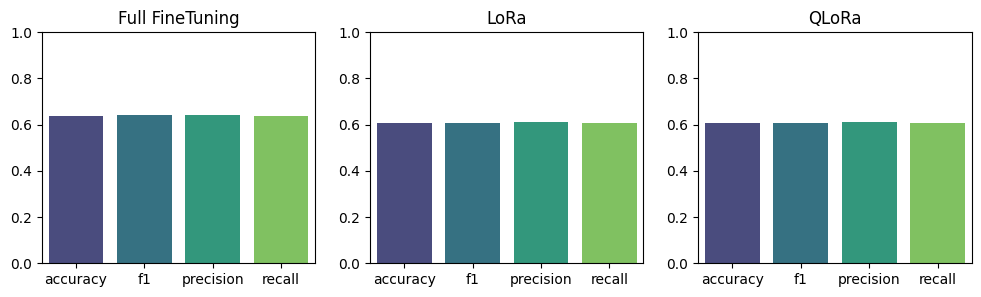

In [55]:
import seaborn as sns 
import matplotlib.pyplot as plt 

# Compare the metrics of all three trained models

fig, ax = plt.subplots(1,3, figsize=(12, 3))
sns.barplot(ax=ax[0], x=["accuracy", "f1", "precision", "recall"], y=[fullfinetune_metrics["eval_accuracy"], fullfinetune_metrics["eval_f1"], fullfinetune_metrics["eval_precision"], fullfinetune_metrics["eval_recall"]], palette="viridis")
sns.barplot(ax=ax[1], x=["accuracy", "f1", "precision", "recall"], y=[lora_metrics["eval_accuracy"], lora_metrics["eval_f1"], lora_metrics["eval_precision"], lora_metrics["eval_recall"]], palette="viridis")
sns.barplot(ax=ax[2], x=["accuracy", "f1", "precision", "recall"], y=[qlora_metrics["eval_accuracy"], qlora_metrics["eval_f1"], qlora_metrics["eval_precision"], qlora_metrics["eval_recall"]], palette="viridis")

models = ["Full FineTuning", "LoRa", "QLoRa"]

for i in range(3):
    ax[i].set_ylim(0,1)
    ax[i].set_title(models[i])
plt.show()

### Conclusion
LoRa and QLoRa achieved the same results as full Fine-Tuning although only less than 1% of all parameters were trained